In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:

# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())


In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in RF feature selection method
feature_names = ['Root10DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot10DaysSeedling', 'Shoot35DaysSeedling', 'Root35DaysSeedling', 
                 'Leaf21DaysSeedling', 'Root14DaysSeedling', 'Shoot3DaysSeedling', 'Root24DaysSeedling', 'Root52DaysSeedling', 
                 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot14DaysSeedling', 'Shoot21DaysSeedling', 'Shoot17DaysSeedling',
                  'ET', 'PCC', 'log_2FoldChange', 'PPI', 'CoExpression' ]

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
1.0      1800
2.0      1296
3.0      1260
4.0      1218
5.0      1026
6.0      1008
7.0       930
8.0       912
9.0       880
10.0      798
11.0      792
12.0      759
13.0      729
14.0      720
15.0      702
16.0      693
17.0      672
18.0      640
19.0      625
20.0      570
21.0      546
22.0      506
23.0      483
24.0      448
25.0      432
26.0      384
27.0      360
28.0      360
29.0      320
30.0      312
         ... 
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      12
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      11
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
373.0      10
Length: 373, dtype: int64


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


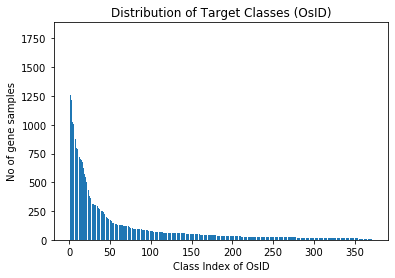

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=140, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of input features: 1
Fold: 1
Epoch 1/140
1846/1846 [==============================] - 4s 2ms/step - loss: 5.0221 - accuracy: 0.0387 - val_loss: 4.9332 - val_accuracy: 0.0315
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.6155 - accuracy: 0.0860 - val_loss: 4.3557 - val_accuracy: 0.1210
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.0445 - accuracy: 0.1251 - val_loss: 3.9867 - val_accuracy: 0.1439
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.7312 - accuracy: 0.1603 - val_loss: 3.7544 - val_accuracy: 0.1945
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.4674 - accuracy: 0.2220 - val_loss: 3.5196 - val_accuracy: 0.2499
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.2293 - accuracy: 0.2677 - val_loss: 3.3389 - val_accuracy: 0.2211
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.0580 - accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.9937 - accuracy: 0.0421 - val_loss: 4.7508 - val_accuracy: 0.1215
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.2978 - accuracy: 0.1173 - val_loss: 4.1423 - val_accuracy: 0.1305
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.8388 - accuracy: 0.1550 - val_loss: 3.8073 - val_accuracy: 0.1314
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.3844 - accuracy: 0.2460 - val_loss: 3.2092 - val_accuracy: 0.3723
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.7397 - accuracy: 0.4058 - val_loss: 2.7491 - val_accuracy: 0.4288
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.3086 - accuracy: 0.4784 - val_loss: 2.4322 - val_accuracy: 0.4935
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.0005 - accuracy: 0.5297 - val_loss: 2.2288 - val_accuracy: 0.55

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.9750 - accuracy: 0.0498 - val_loss: 4.6189 - val_accuracy: 0.1021
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.2175 - accuracy: 0.1216 - val_loss: 4.1097 - val_accuracy: 0.1331
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.8314 - accuracy: 0.1659 - val_loss: 3.8302 - val_accuracy: 0.1934
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.4227 - accuracy: 0.2662 - val_loss: 3.2500 - val_accuracy: 0.3672
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.6854 - accuracy: 0.3950 - val_loss: 2.6858 - val_accuracy: 0.4257
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.1766 - accuracy: 0.4666 - val_loss: 2.2992 - val_accuracy: 0.4722
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.8709 - accuracy: 0.5131 - val_loss: 2.1290 - val_accuracy: 0.56

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 5.0232 - accuracy: 0.0422 - val_loss: 4.8169 - val_accuracy: 0.0961
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.0590 - accuracy: 0.1950 - val_loss: 3.5658 - val_accuracy: 0.3314
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.9742 - accuracy: 0.4035 - val_loss: 2.7615 - val_accuracy: 0.4530
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.2837 - accuracy: 0.5214 - val_loss: 2.2573 - val_accuracy: 0.5465
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.8288 - accuracy: 0.5942 - val_loss: 1.9837 - val_accuracy: 0.6482
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.5434 - accuracy: 0.6432 - val_loss: 1.7895 - val_accuracy: 0.6513
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.3689 - accuracy: 0.6729 - val_loss: 1.7273 - val_accuracy: 0.64

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.7752 - accuracy: 0.0639 - val_loss: 4.2258 - val_accuracy: 0.1197
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.7132 - accuracy: 0.2357 - val_loss: 3.5355 - val_accuracy: 0.3193
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.9901 - accuracy: 0.4000 - val_loss: 2.9319 - val_accuracy: 0.4576
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.4216 - accuracy: 0.4868 - val_loss: 2.5378 - val_accuracy: 0.5039
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.9881 - accuracy: 0.5367 - val_loss: 2.2074 - val_accuracy: 0.5714
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.6839 - accuracy: 0.5867 - val_loss: 2.0054 - val_accuracy: 0.5813
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.4844 - accuracy: 0.6313 - val_loss: 1.8189 - val_accuracy: 0.66

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.7469 - accuracy: 0.0738 - val_loss: 4.2192 - val_accuracy: 0.1199
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.6011 - accuracy: 0.2577 - val_loss: 3.2234 - val_accuracy: 0.4169
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.6649 - accuracy: 0.4337 - val_loss: 2.6558 - val_accuracy: 0.4779
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.1109 - accuracy: 0.5275 - val_loss: 2.2463 - val_accuracy: 0.6055
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.7033 - accuracy: 0.6200 - val_loss: 1.9399 - val_accuracy: 0.6543
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.4373 - accuracy: 0.6663 - val_loss: 1.8185 - val_accuracy: 0.6288
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.2534 - accuracy: 0.7006 - val_loss: 1.6287 - val_accuracy: 0.70

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.4059 - accuracy: 0.1068 - val_loss: 3.8748 - val_accuracy: 0.1707
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.3340 - accuracy: 0.3002 - val_loss: 2.9810 - val_accuracy: 0.4506
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.3413 - accuracy: 0.5321 - val_loss: 2.1740 - val_accuracy: 0.5749
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.6911 - accuracy: 0.6317 - val_loss: 1.6953 - val_accuracy: 0.6587
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.3237 - accuracy: 0.6929 - val_loss: 1.4316 - val_accuracy: 0.7014
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.1008 - accuracy: 0.7273 - val_loss: 1.2487 - val_accuracy: 0.7397
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.9557 - accuracy: 0.7549 - val_loss: 1.1477 - val_accuracy: 0.75

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.6857 - accuracy: 0.0852 - val_loss: 4.0476 - val_accuracy: 0.2068
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.4129 - accuracy: 0.3132 - val_loss: 3.1683 - val_accuracy: 0.4220
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.6304 - accuracy: 0.4726 - val_loss: 2.6176 - val_accuracy: 0.5261
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.1140 - accuracy: 0.5589 - val_loss: 2.2460 - val_accuracy: 0.5771
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.7547 - accuracy: 0.6211 - val_loss: 1.9952 - val_accuracy: 0.6455
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.4838 - accuracy: 0.6664 - val_loss: 1.8081 - val_accuracy: 0.6880
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.3096 - accuracy: 0.6988 - val_loss: 1.6927 - val_accuracy: 0.69

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.4207 - accuracy: 0.1063 - val_loss: 3.8635 - val_accuracy: 0.1547
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.3988 - accuracy: 0.2283 - val_loss: 3.1870 - val_accuracy: 0.3648
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.5944 - accuracy: 0.4482 - val_loss: 2.4082 - val_accuracy: 0.5404
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.9297 - accuracy: 0.5928 - val_loss: 1.9260 - val_accuracy: 0.6385
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.5019 - accuracy: 0.6728 - val_loss: 1.6165 - val_accuracy: 0.6884
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.2425 - accuracy: 0.7153 - val_loss: 1.4114 - val_accuracy: 0.7250
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.0792 - accuracy: 0.7381 - val_loss: 1.3506 - val_accuracy: 0.74

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.5092 - accuracy: 0.0919 - val_loss: 4.0001 - val_accuracy: 0.1039
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.5558 - accuracy: 0.1915 - val_loss: 3.3703 - val_accuracy: 0.2339
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.8341 - accuracy: 0.3842 - val_loss: 2.6556 - val_accuracy: 0.4444
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.1107 - accuracy: 0.5386 - val_loss: 2.1000 - val_accuracy: 0.5936
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.6406 - accuracy: 0.6305 - val_loss: 1.7672 - val_accuracy: 0.6486
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.3578 - accuracy: 0.6847 - val_loss: 1.5530 - val_accuracy: 0.6774
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.1696 - accuracy: 0.7223 - val_loss: 1.4067 - val_accuracy: 0.72

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.6109 - accuracy: 0.0746 - val_loss: 4.1076 - val_accuracy: 0.1347
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.6365 - accuracy: 0.2063 - val_loss: 3.4612 - val_accuracy: 0.2876
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.9008 - accuracy: 0.3782 - val_loss: 2.8338 - val_accuracy: 0.4158
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.3377 - accuracy: 0.4778 - val_loss: 2.4049 - val_accuracy: 0.5677
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.9181 - accuracy: 0.5760 - val_loss: 2.1286 - val_accuracy: 0.6218
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.6181 - accuracy: 0.6409 - val_loss: 1.8749 - val_accuracy: 0.6865
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.4054 - accuracy: 0.6792 - val_loss: 1.7614 - val_accuracy: 0.66

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.5373 - accuracy: 0.0785 - val_loss: 4.1050 - val_accuracy: 0.0803
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.6954 - accuracy: 0.1688 - val_loss: 3.5743 - val_accuracy: 0.1692
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.1397 - accuracy: 0.2679 - val_loss: 3.0321 - val_accuracy: 0.3223
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.4395 - accuracy: 0.4449 - val_loss: 2.3876 - val_accuracy: 0.5168
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.9064 - accuracy: 0.5554 - val_loss: 2.0238 - val_accuracy: 0.6000
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.5804 - accuracy: 0.6226 - val_loss: 1.8320 - val_accuracy: 0.6561
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.3625 - accuracy: 0.6774 - val_loss: 1.6710 - val_accuracy: 0.68

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.5460 - accuracy: 0.0810 - val_loss: 4.0707 - val_accuracy: 0.0977
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.6493 - accuracy: 0.1852 - val_loss: 3.5586 - val_accuracy: 0.2473
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.1529 - accuracy: 0.2842 - val_loss: 3.1132 - val_accuracy: 0.3402
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.6062 - accuracy: 0.4261 - val_loss: 2.5894 - val_accuracy: 0.4933
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.0924 - accuracy: 0.5581 - val_loss: 2.2585 - val_accuracy: 0.6000
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.7357 - accuracy: 0.6190 - val_loss: 1.9831 - val_accuracy: 0.6312
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.4809 - accuracy: 0.6629 - val_loss: 1.8133 - val_accuracy: 0.68

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.7285 - accuracy: 0.0646 - val_loss: 4.2026 - val_accuracy: 0.1025
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.7650 - accuracy: 0.1720 - val_loss: 3.5854 - val_accuracy: 0.2202
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.0703 - accuracy: 0.3403 - val_loss: 2.9374 - val_accuracy: 0.4433
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.4122 - accuracy: 0.4977 - val_loss: 2.4513 - val_accuracy: 0.5276
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.9203 - accuracy: 0.5762 - val_loss: 2.0510 - val_accuracy: 0.6059
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.5622 - accuracy: 0.6507 - val_loss: 1.8298 - val_accuracy: 0.6851
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.3019 - accuracy: 0.7101 - val_loss: 1.6255 - val_accuracy: 0.72

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.7246 - accuracy: 0.0646 - val_loss: 4.2322 - val_accuracy: 0.0882
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.7478 - accuracy: 0.1565 - val_loss: 3.5127 - val_accuracy: 0.1985
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.0513 - accuracy: 0.3212 - val_loss: 2.8865 - val_accuracy: 0.4614
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.4294 - accuracy: 0.4904 - val_loss: 2.3894 - val_accuracy: 0.5272
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.9689 - accuracy: 0.5619 - val_loss: 2.0554 - val_accuracy: 0.6002
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.6515 - accuracy: 0.6167 - val_loss: 1.7975 - val_accuracy: 0.6420
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.4027 - accuracy: 0.6689 - val_loss: 1.6517 - val_accuracy: 0.66

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.7395 - accuracy: 0.0677 - val_loss: 4.2542 - val_accuracy: 0.1056
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.8631 - accuracy: 0.1657 - val_loss: 3.7133 - val_accuracy: 0.1782
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.4142 - accuracy: 0.2122 - val_loss: 3.3262 - val_accuracy: 0.2574
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.9239 - accuracy: 0.3215 - val_loss: 2.8084 - val_accuracy: 0.3914
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.3466 - accuracy: 0.4673 - val_loss: 2.3227 - val_accuracy: 0.5219
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.9139 - accuracy: 0.5619 - val_loss: 2.0476 - val_accuracy: 0.5729
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.6270 - accuracy: 0.6271 - val_loss: 1.8081 - val_accuracy: 0.62

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.7518 - accuracy: 0.0656 - val_loss: 4.2528 - val_accuracy: 0.0895
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.8629 - accuracy: 0.1563 - val_loss: 3.6989 - val_accuracy: 0.1615
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.3684 - accuracy: 0.2167 - val_loss: 3.3051 - val_accuracy: 0.2416
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.9630 - accuracy: 0.2962 - val_loss: 2.8700 - val_accuracy: 0.3503
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.4622 - accuracy: 0.4188 - val_loss: 2.4310 - val_accuracy: 0.4812
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.1009 - accuracy: 0.4987 - val_loss: 2.1224 - val_accuracy: 0.5300
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.8279 - accuracy: 0.5599 - val_loss: 1.9440 - val_accuracy: 0.57

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.7985 - accuracy: 0.0633 - val_loss: 4.3541 - val_accuracy: 0.0860
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.9809 - accuracy: 0.1414 - val_loss: 3.8283 - val_accuracy: 0.1435
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.4479 - accuracy: 0.2057 - val_loss: 3.2985 - val_accuracy: 0.2359
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.9151 - accuracy: 0.3106 - val_loss: 2.8014 - val_accuracy: 0.3595
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.4075 - accuracy: 0.4253 - val_loss: 2.4689 - val_accuracy: 0.3769
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.0809 - accuracy: 0.4814 - val_loss: 2.1754 - val_accuracy: 0.4656
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.8566 - accuracy: 0.5165 - val_loss: 1.9755 - val_accuracy: 0.54

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.8595 - accuracy: 0.0610 - val_loss: 4.5384 - val_accuracy: 0.0959
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.1487 - accuracy: 0.1214 - val_loss: 3.9943 - val_accuracy: 0.1450
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.7111 - accuracy: 0.1737 - val_loss: 3.6621 - val_accuracy: 0.1978
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.3930 - accuracy: 0.2159 - val_loss: 3.3594 - val_accuracy: 0.2524
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.0101 - accuracy: 0.2954 - val_loss: 2.9757 - val_accuracy: 0.3204
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.6129 - accuracy: 0.3856 - val_loss: 2.6359 - val_accuracy: 0.4097
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.3202 - accuracy: 0.4421 - val_loss: 2.4085 - val_accuracy: 0.45

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.8553 - accuracy: 0.0613 - val_loss: 4.5013 - val_accuracy: 0.1025
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.1190 - accuracy: 0.1284 - val_loss: 3.9905 - val_accuracy: 0.1487
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.6886 - accuracy: 0.1822 - val_loss: 3.6318 - val_accuracy: 0.1817
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.3130 - accuracy: 0.2313 - val_loss: 3.2661 - val_accuracy: 0.2590
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.9050 - accuracy: 0.3235 - val_loss: 2.8942 - val_accuracy: 0.3342
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.5411 - accuracy: 0.3951 - val_loss: 2.5979 - val_accuracy: 0.4183
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.2573 - accuracy: 0.4497 - val_loss: 2.3377 - val_accuracy: 0.47

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

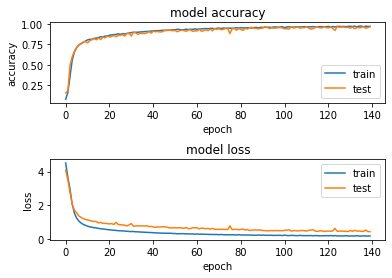

Final Test Accuracy: 0.9721382856369019


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       0.97      1.00      0.98       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os01g0862800         331              101       False
1  Os01g0173100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.489
1,2,0.831
2,3,0.906
3,4,0.940
4,5,0.911
5,6,0.960
6,7,0.957
7,8,0.956
8,9,0.964
9,10,0.952
